### Загрузим данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

Импортируем библиотеки

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

Загружаем данные и переводим в нужный формат некоторые столбцы(в datetime)

In [15]:
sessions = pd.read_csv('/datasets/visits_info_short.csv')
sessions.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders = pd.read_csv('/datasets/orders_info_short.csv')
orders.columns = ['user_id', 'event_dt', 'revenue']
ad_costs = pd.read_csv('/datasets/costs_info_short.csv')
ad_costs.columns = ad_costs.columns.str.lower()
sessions.session_start = pd.to_datetime(sessions.session_start)
sessions.session_end = pd.to_datetime(sessions.session_end)
orders.event_dt = pd.to_datetime(orders.event_dt)
ad_costs.dt = pd.to_datetime(ad_costs.dt)

In [16]:
sessions.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [17]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [18]:
sessions.duplicated().sum()

0

In [19]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [20]:
orders.duplicated().sum()

0

In [21]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [22]:
ad_costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [23]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [24]:
ad_costs.duplicated().sum()

0

Пропуски и дубликаты в данных отсутствуют

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Задаем функцию для получения профилей пользователей

In [25]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

   
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
        
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs['dt'] = ad_costs['dt'].dt.date
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Задаем функцию для получения RR(коэффициента удержания)

In [26]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Задаем функцию для получения CR (коэффициента конверсии)

In [27]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Задаем функцию для получения LTV и ROI(прибыль от пользователей, окупаемость рекламы)

In [28]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Задаем функцию для сглаживания графика

In [29]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Задаем функцию для построения графиков удержания

In [30]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Задаем функцию для построения графиков конверсии

In [31]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Задаем функцию для построения графиков LTV, CAC и ROI

In [32]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

Получаем профили пользователь, используя функцию get_profiles

In [33]:
profiles = get_profiles(sessions, orders, ad_costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определяем минимальнкю и максимальную дату наблюдения

In [34]:
profiles.first_ts.dt.date.min()

datetime.date(2019, 5, 1)

In [35]:
profiles.first_ts.dt.date.max()

datetime.date(2019, 10, 27)

В датафрейме данные за период времени с 01.05.2019 по 27.10.2019, что совпадает с нашим исследуемым периодом.

Напишем простую функцию для группировки

In [57]:
def get_pivot(profiles, feature):
    pivot = profiles.groupby(feature)['payer'].agg({'count','sum'}).rename({'sum':'payers', 'count':'total_count'}, axis='columns')
    pivot['payers_rate'] = pivot.payers / pivot.total_count
    return pivot

Группируем профили по стране и расчитываем кол-во плательщиков, общее количество пользователей и долю плательщиков.

In [58]:
pivot_region = get_pivot(profiles, 'region')
pivot_region.sort_values(by='payers_rate', ascending=False)

,total_count,payers,payers_rate
region,,,
United States,100002,6902,0.069019
Germany,14981,616,0.041119
UK,17575,700,0.039829
France,17450,663,0.037994


Больше всего платных пользователей оказывается в США, их там 6,9% от всеъ пользователей в США(100002 человека)

Сходным образом анализируем вид устройства пользователей

In [38]:
pivot_device = get_pivot(profiles, 'device')
pivot_device.sort_values(by='payers_rate', ascending=False)

,total_count,payers,payers_rate
device,,,
Mac,30042,1912,0.063644
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468


Набольший коэффициент конверсии в платных среди пользователей которые заходят в приложение через Mac - 6,36%

Проанализируем источники из которых приходят пользователи

In [42]:
pivot_channel = get_pivot(profiles, 'channel')
pivot_channel.sort_values(by='payers_rate', ascending=False)

,total_count,payers,payers_rate
channel,,,
FaceBoom,29144,3557,0.122049
AdNonSense,3880,440,0.113402
lambdaMediaAds,2149,225,0.104700
TipTop,19561,1878,0.096007
RocketSuperAds,4448,352,0.079137
WahooNetBanner,8553,453,0.052964
YRabbit,4312,165,0.038265
MediaTornado,4364,156,0.035747
LeapBob,8553,262,0.030633


Больше всего платных пользователей пришло из FaceBoom

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

Посчитаем общую сумму расходов на маркетинг

In [21]:
ad_costs.costs.sum()

105497.30000000002

Посмотрим на распределение расходов по источникам

In [22]:
ad_costs.groupby('channel')['costs'].agg('sum').sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

Больше всего денег вложено в рекламу на TipTop(54751.30), на втором месте FaceBoom(32445), на остальные платформы потрачено значительно меньше средств

Визуализируем распределение расходов по времени на разные источники

In [23]:
ad_cost_1 = ad_costs.copy()
ad_cost_1['dt'] = pd.to_datetime(ad_cost_1['dt']).dt.isocalendar().week

In [24]:
ad_costs_group_1 = ad_cost_1.groupby(['channel','dt'])['costs'].agg('sum').sort_values(ascending=False).reset_index()

In [25]:
ad_costs_group_1.pivot_table(index='dt',columns='channel', values='costs', aggfunc='sum')

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
18,211.05,535.7,16.80,38.64,24.00,99.450,347.0,49.2,52.20,81.6
19,273.00,750.2,31.71,61.68,34.50,139.230,470.0,92.4,75.90,103.2
20,265.65,755.7,26.67,59.04,27.50,138.060,454.0,90.0,69.30,90.4
21,266.70,722.7,26.67,50.16,34.25,131.040,801.8,79.2,65.40,119.2
22,202.65,1208.9,65.52,36.96,81.75,97.695,1421.2,179.4,49.80,83.2
23,102.90,1081.3,66.99,27.60,79.50,76.050,1223.6,196.8,25.80,35.2
24,96.60,1042.8,52.29,29.76,71.50,63.180,1121.0,166.2,17.46,45.6
25,141.75,1280.4,68.46,32.16,79.75,80.730,1474.4,201.6,22.14,40.0
26,148.05,1647.8,99.75,40.56,107.00,78.260,2343.6,285.0,27.90,59.2


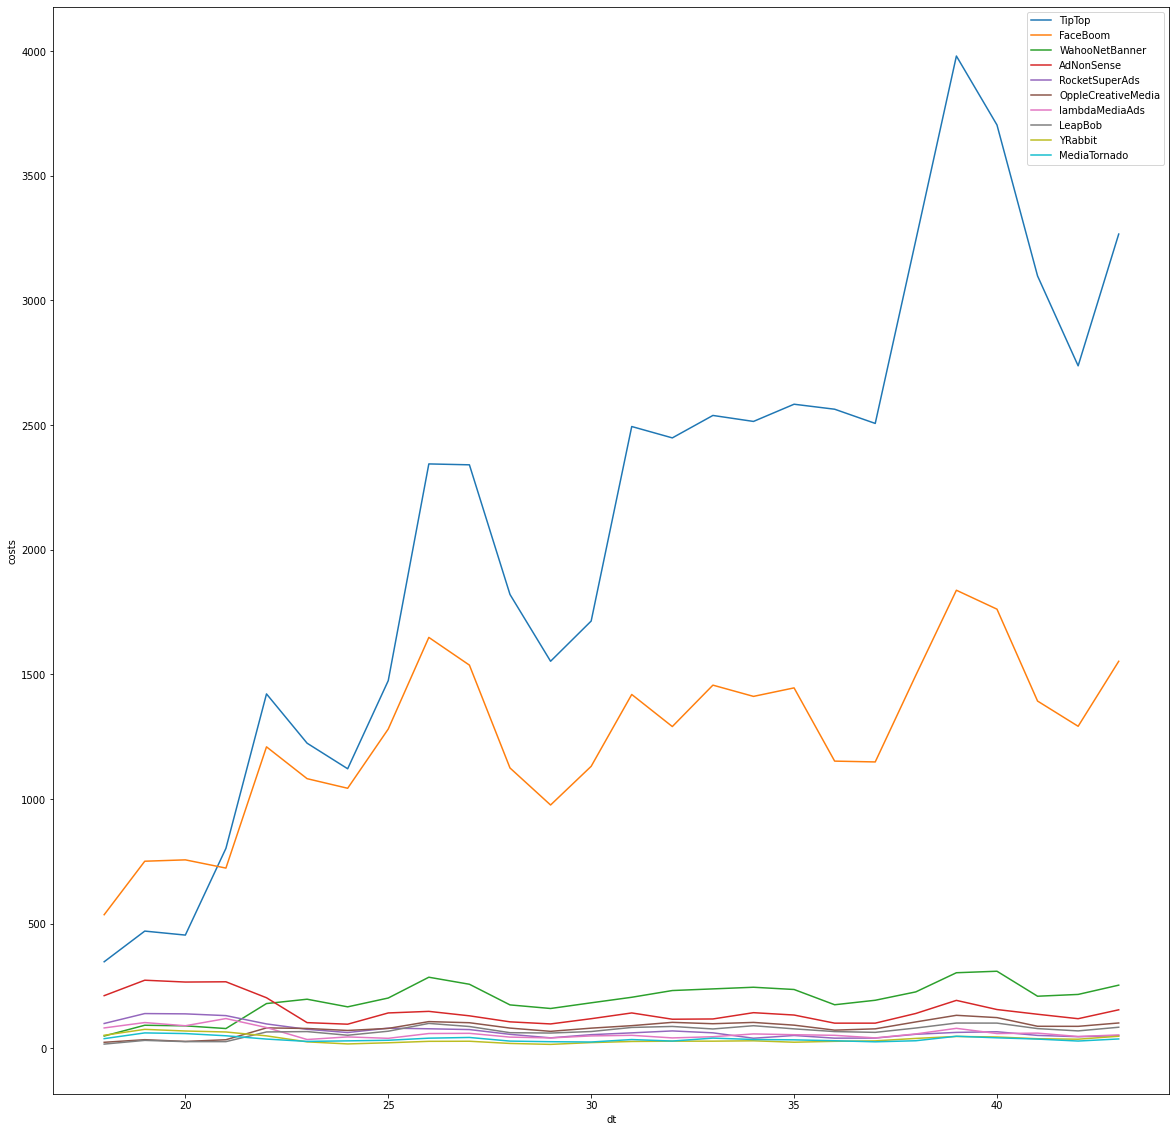

In [26]:
fig, ax = plt.subplots(figsize=(20,20))
for channel in ad_costs_group_1.channel.unique():
    sns.lineplot(data=ad_costs_group_1[ad_costs_group_1['channel']==channel],x='dt', y='costs', legend='full')
plt.legend(labels=ad_costs_group_1.channel.unique())
plt.show()

In [27]:
ad_cost_2 = ad_costs.copy()
ad_cost_2['dt'] = pd.to_datetime(ad_cost_2['dt']).dt.month
ad_cost_2['dt']
ad_costs_group_2 = ad_cost_2.groupby(['channel','dt'])['costs'].agg('sum').sort_values(ascending=False).reset_index()
ad_costs_group_2.pivot_table(index='dt',columns='channel', values='costs', aggfunc='sum')

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
5,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
6,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
7,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
8,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
9,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
10,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


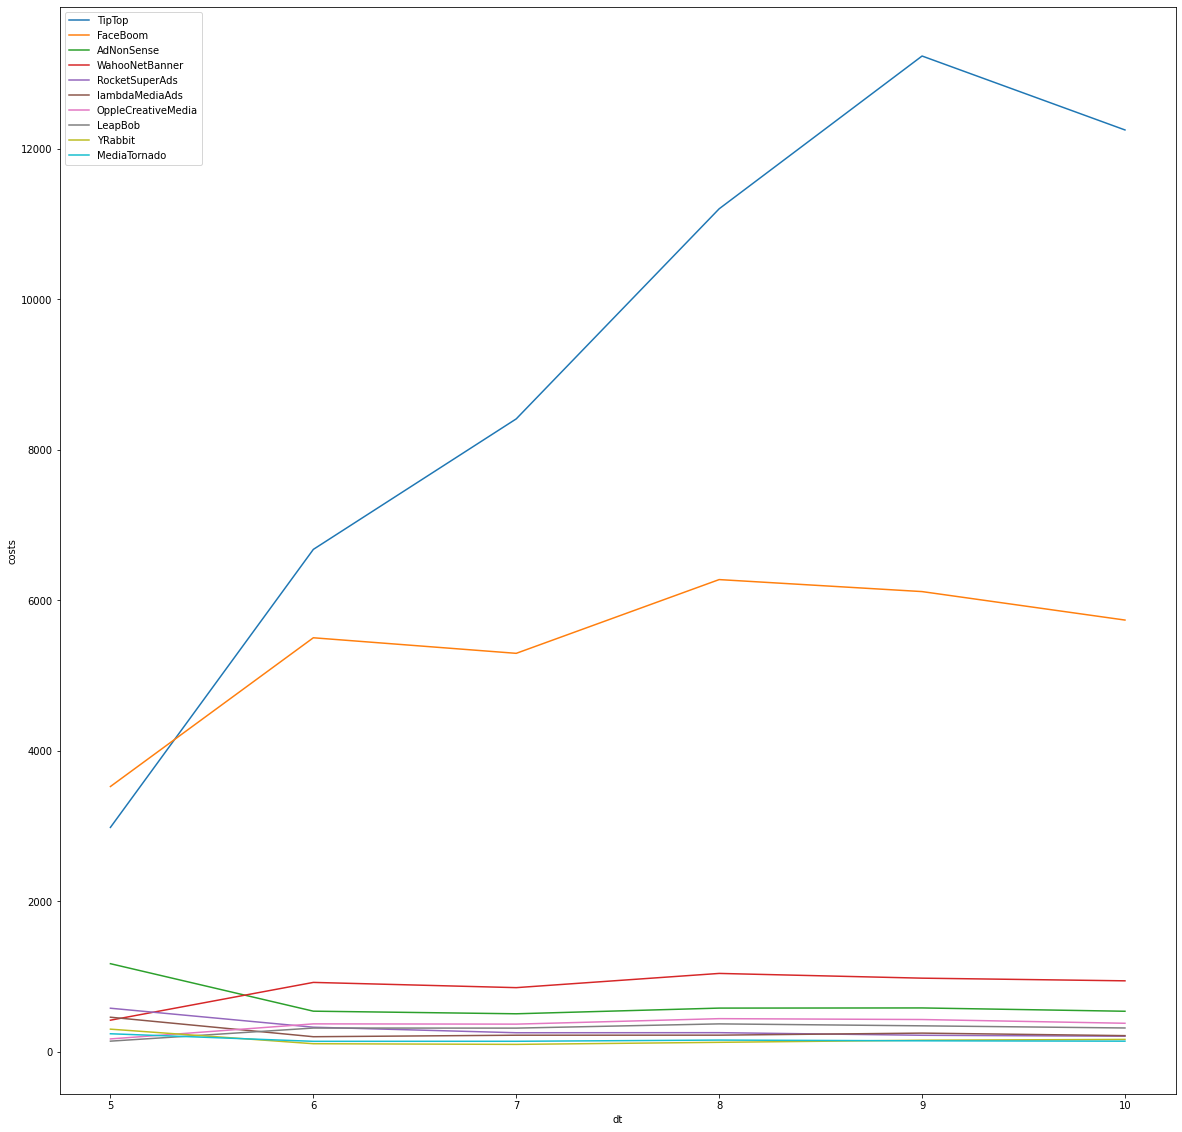

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
for channel in ad_costs_group_2.channel.unique():
    sns.lineplot(data=ad_costs_group_2[ad_costs_group_2['channel']==channel],x='dt', y='costs', legend='full')
plt.legend(labels=ad_costs_group_2.channel.unique())
plt.show()

Видно, что затраты на TipTop росли почти до самого конца, тогда как FaceBoom вышли на своебразное плато в июне. Расходы на другие источники довольно низкие

Теперь посчитаем средний САС для каждого источника.

In [29]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [30]:
profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Неудивительно, что САС для TipTop больше чем в два раза больше FaceBoom

Наибольший коэффициент привлечения платных пользователей у FaceBoom, а TipTop занимает в этом плане 4 место, однако по затратам на рекламу и САС TipTop значительно превышает другие каналы привлечения.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Убираем из датафрейма органических пользователей

In [62]:
profiles_nonorganic = profiles[profiles.channel != 'organic']

In [63]:
observation_date = pd.to_datetime('2019-11-1')
observation_date
horizon_days=14
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_nonorganic,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

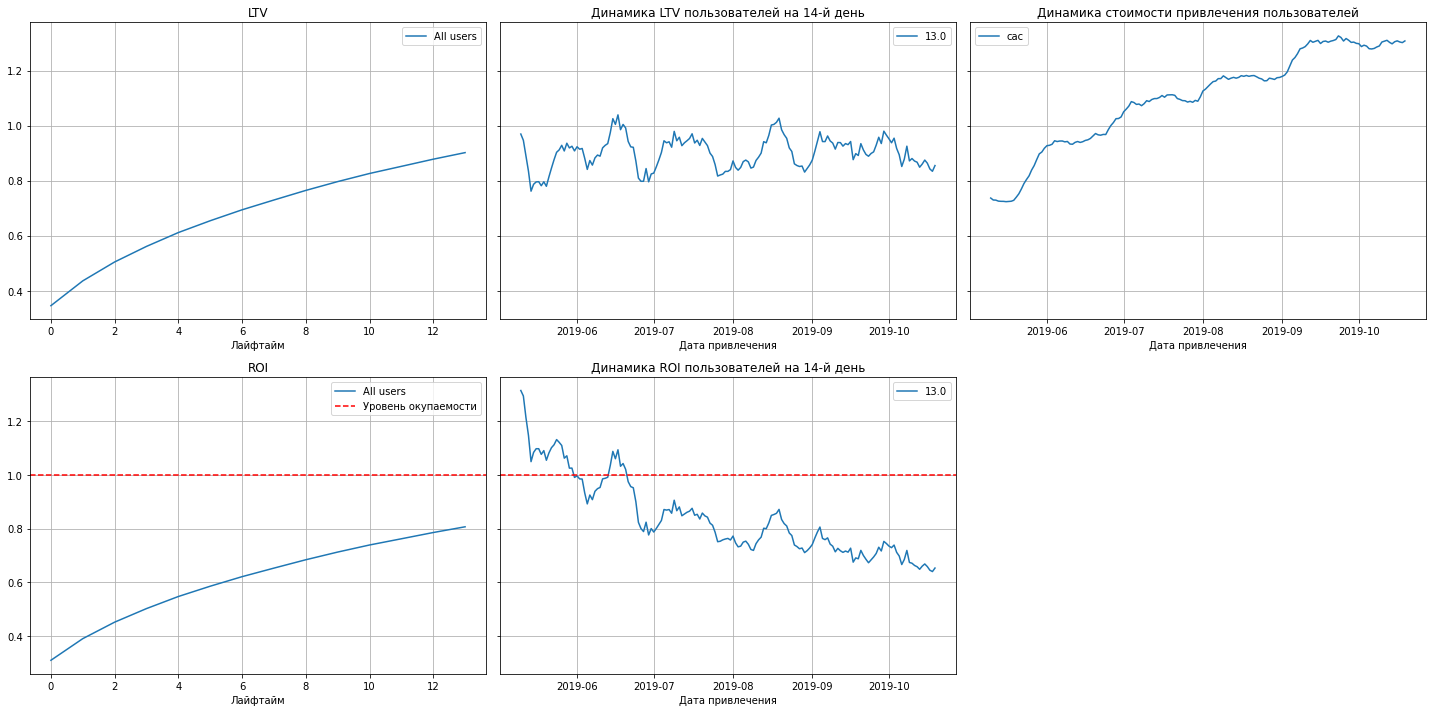

In [65]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=10)

Реклама не окупается, график ROI не выходит за границу окупаемости, стоимость привлечения пользователей растет быстрее чем прибыль с них.

Проверим конверсию пользователей в покупателей

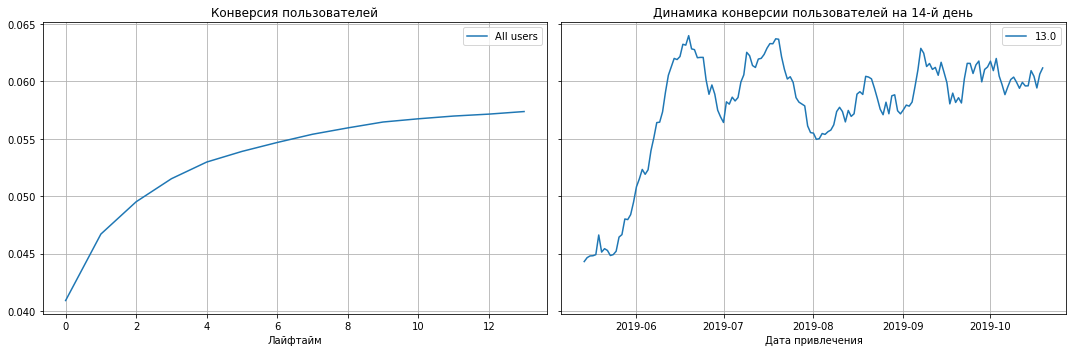

In [66]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)
plot_conversion(result_grouped, result_in_time, horizon_days, window=14)

Конверсия достигает плато примерно на 8 день, максимум ее примерно 5,75%

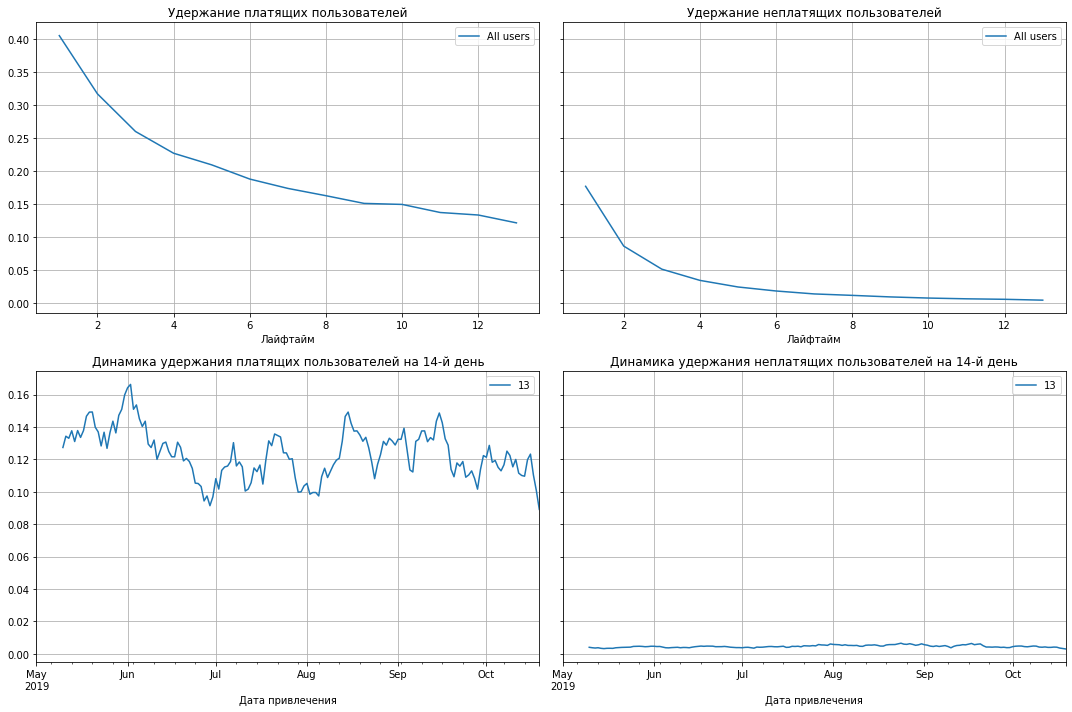

In [67]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)
plot_retention(result_grouped, result_in_time, horizon_days, window=10)

На 13 день RR составляет примерно 12,5% для платящих и стремится к нулю для неплатящих пользователей

Проанализируем окупаемость рекламы с разбивкой по устройтствам

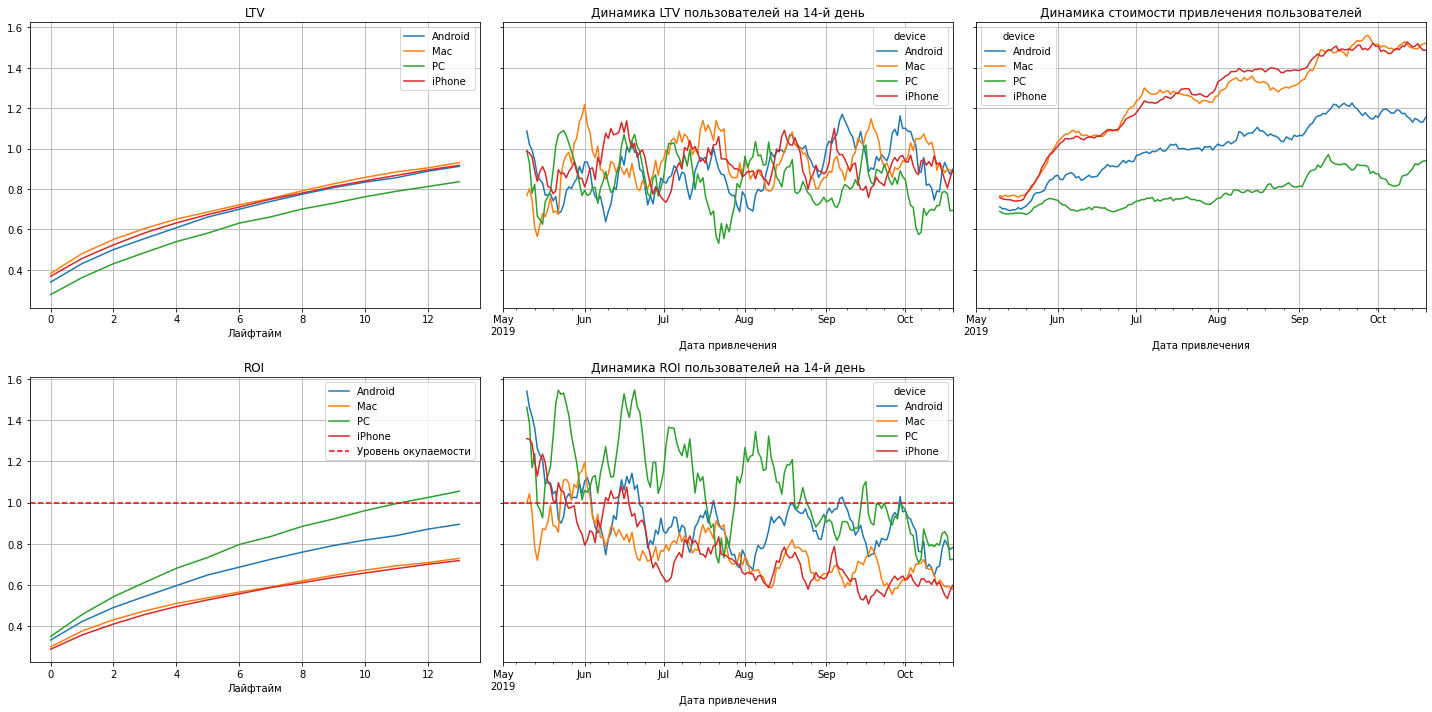

In [68]:
observation_date = pd.to_datetime('2019-11-1')
observation_date
horizon_days=14
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_nonorganic,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=10)

Стоимость привлечения для Mac и iPhone больше, чем для других платформ и в итоге так и не окупается(хоть LTV и немного выше). Android и PC приносят немного меньше прибыли(по LTV), однако CAC для них меньше и они окупаются на 10 и 7 день соответственно. Лучше всего окупаются пользователи на PC

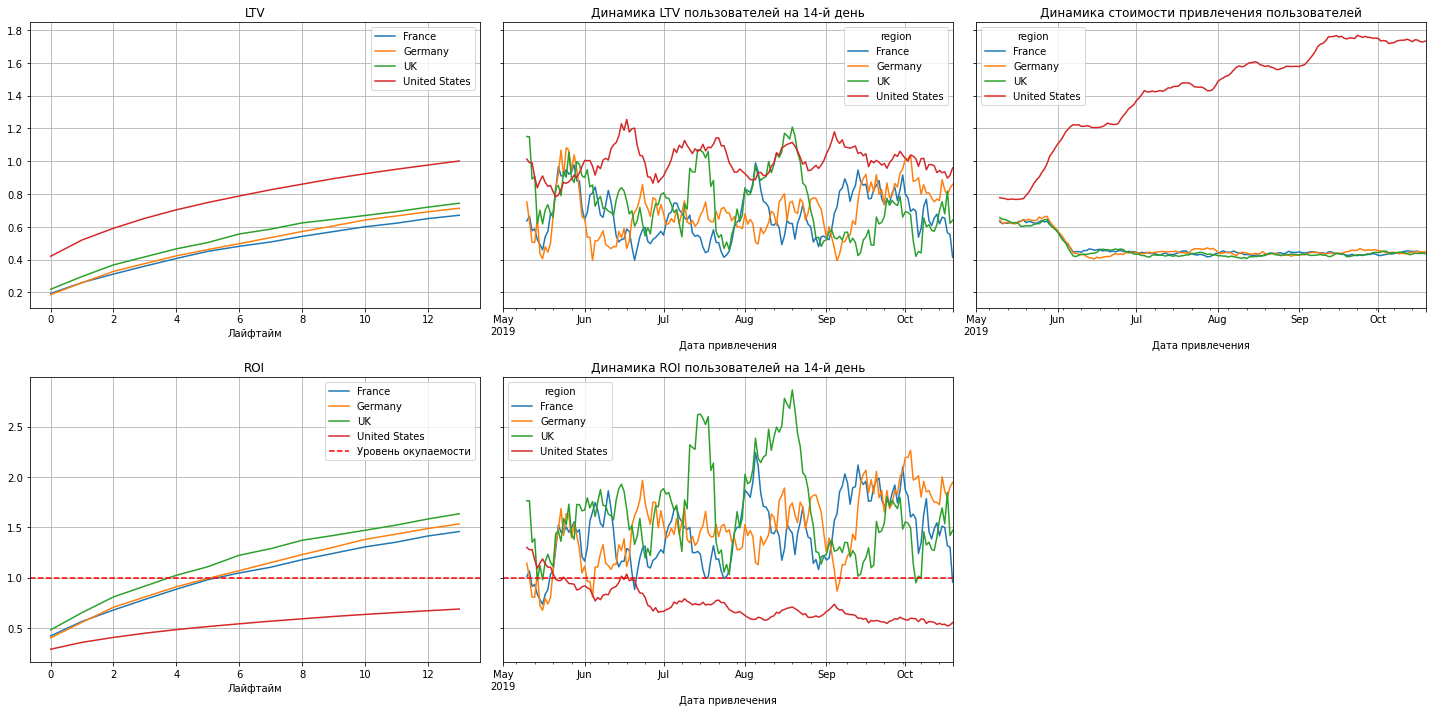

In [69]:
observation_date = pd.to_datetime('2019-11-1')
observation_date
horizon_days=14
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_nonorganic,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=10)

Хотьпользователи из США и приносят больше прибыли, однако затраты на их привлечение сильно выросли с июня, поэтому пользователи из США не окупаются, пользователи из других стран окупаются примерно одинаково

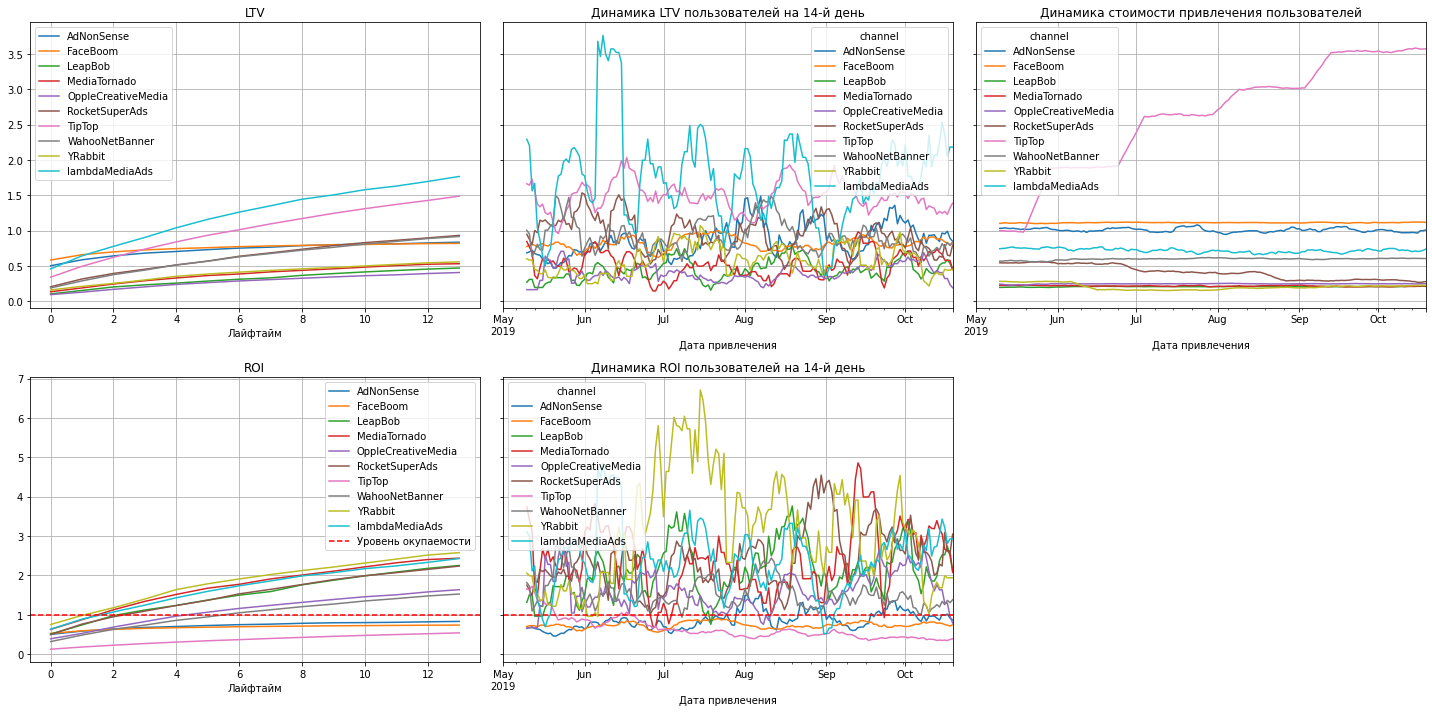

In [70]:
observation_date = pd.to_datetime('2019-11-1')
observation_date
horizon_days=14
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_nonorganic,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=10)

Проверим конверсию и удержание по каналам привлечения

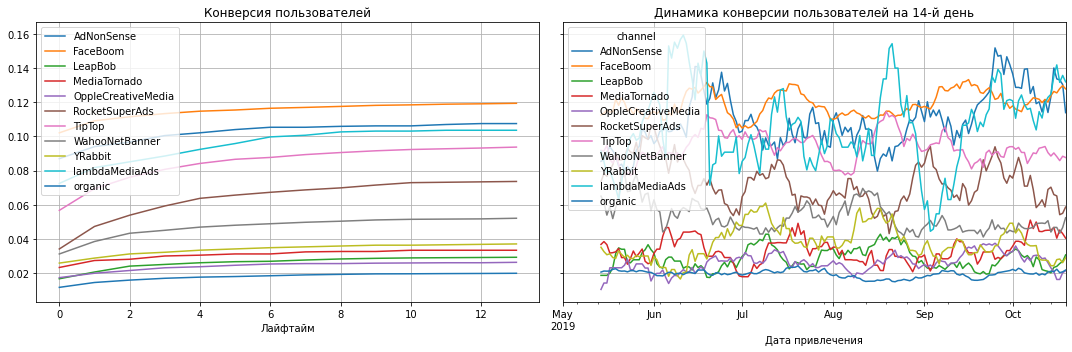

In [74]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_conversion(result_grouped, result_in_time, horizon_days, window=14)

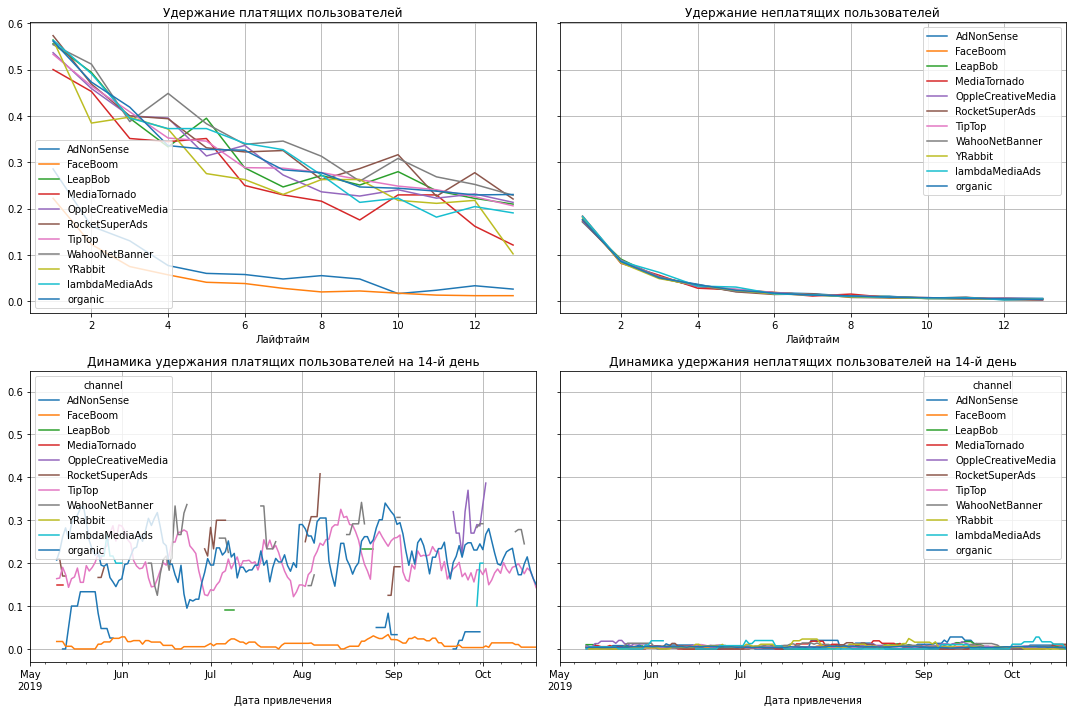

In [76]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_retention(result_grouped, result_in_time, horizon_days, window=10)

Реклама в целом не окупается, негативное влияние оказывает большие затраты на рекламу в США, на рекламу в TipTop

Не окупаются пользователи пришедшие с FaceBoom, TipTop и AdNonSense. Вероятно это связано с большим увеличением стоимости привлечения пользователей с TipTop, низким удержанием пользователей с FaceBoom(при достаточно высокой, хоть и постоянной CAC, и неплохой конверсии), и очень низким LTV(при высоком CAC) пользователей с AdNonSense. Стоит сконцентрироваться на LambdaMediaAds, YRabbit  и других

Посмотрим на парметры США более пристально

In [89]:
profiles_USA = profiles_nonorganic[profiles.region == 'United States']

/tmp/ipykernel_31/3721472890.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  profiles_USA = profiles_nonorganic[profiles.region == 'United States']


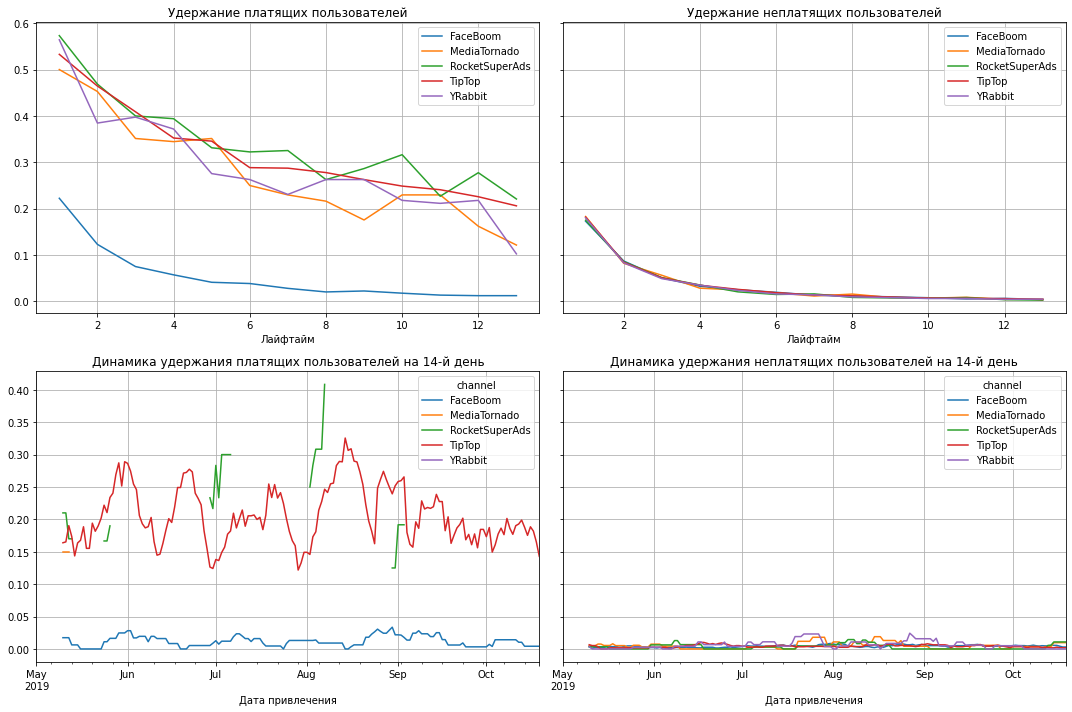

In [86]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles_USA,
    sessions,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_retention(result_grouped, result_in_time, horizon_days, window=10)

Удержание примерно одинаковое для каналов, кроме FaceBoom

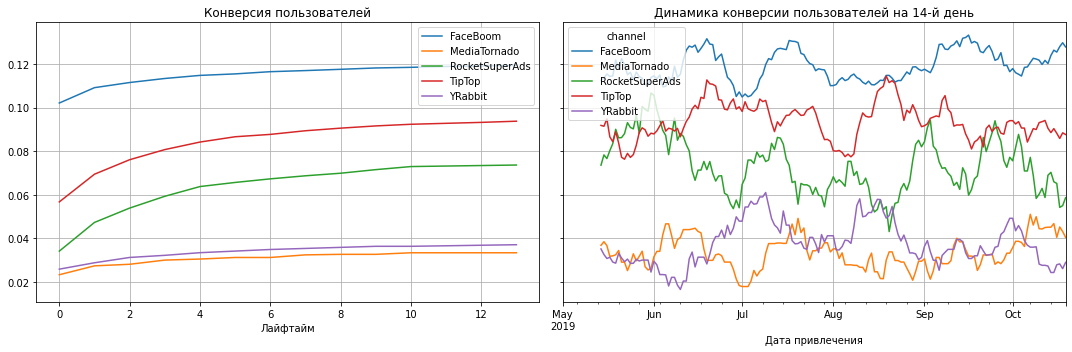

In [87]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles_USA,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_conversion(result_grouped, result_in_time, horizon_days, window=14)

Самая высокая конверсия у FaceBoom, на втором месте - TipTop, на третьем RocketSuperAds

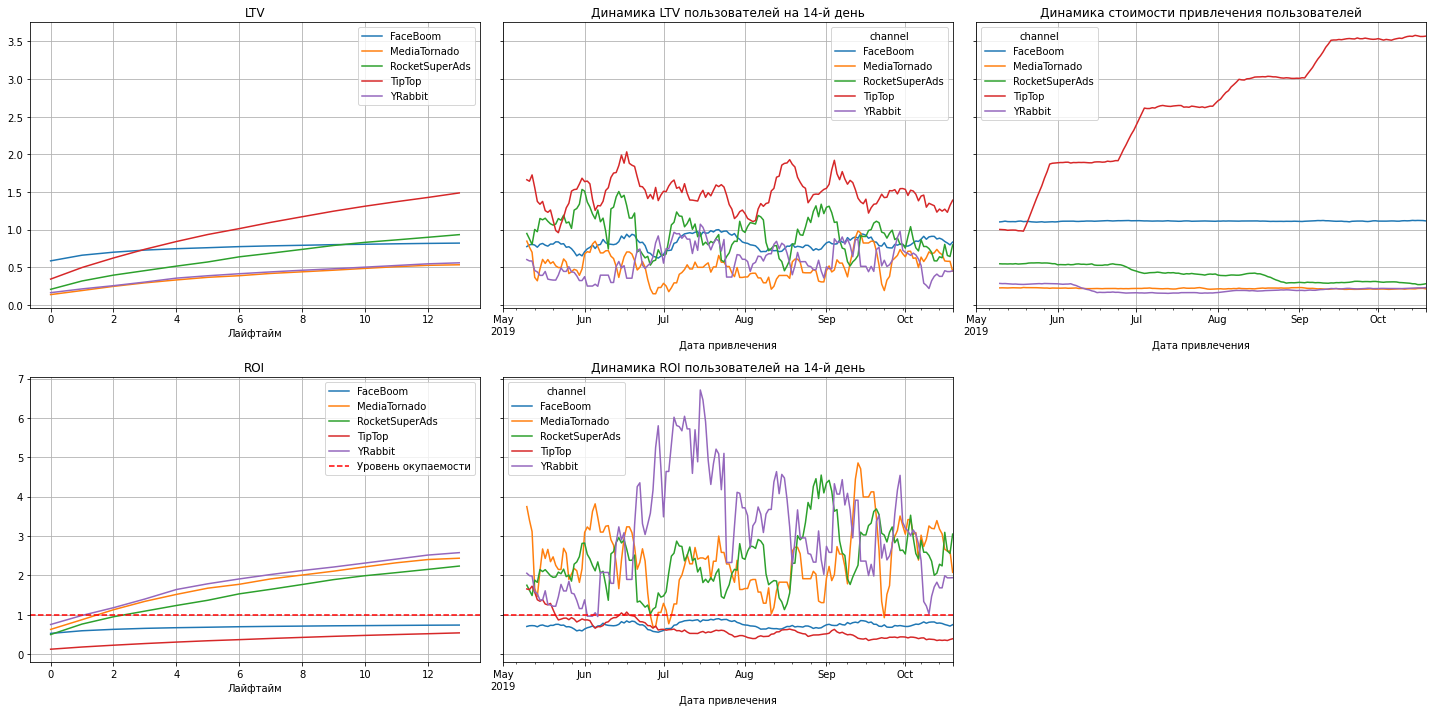

In [88]:
observation_date = pd.to_datetime('2019-11-1')
observation_date
horizon_days=14
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_USA,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=10)

Лучше всего окупается Yrabbit, Media Tornado и RocketSuperAds

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Выводы:
* Была проведена предобработка данных, колонки приведены к необходимым форматам, проведена проверка на дубликаты и пропуски
* Определены функции, которые будут использоваться в аналитике
* Проведен исследовательский анализ: было опредено, что больше всего платных пользователей в США (коэфициент конверсии 6,9%), и коэфициент конверсии в платных пользователей так же набольший среди пользователей Mac(6,36%)
* Больше всего платный пользователей пришло из FaceBoom (3557), коэфициент конверсии- 12,2%
* Всего на маркетинг потрачено 105497.3
* Больше всего денег вложено в рекламу на TipTop(54751.30), на втором месте FaceBoom(32445), на остальные платформы потрачено значительно меньше средств
* Видно, что затраты на TipTop росли почти до самого конца, тогда как FaceBoom вышли на своебразное плато в июне. Расходы на другие источники довольно низкие. 
* Стоимость привлечени клиента для TipTop - 2.799003, для FaceBoom	1.113286, для AdNonSense 1.008054. Для остальных платформ значительно меньше
* Наибольший коэффициент привлечения платных пользователей у FaceBoom, а TipTop занимает в этом плане 4 место, однако по затратам на рекламу и САС TipTop значительно превышает другие каналы привлечения.
* В целом реклама не окупается, график ROI не выходит за границу окупаемости, стоимость привлечения пользователей растет быстрее чем прибыль с них
* Конверсия достигает плато примерно на 8 день, максимум ее примерно 5,75%
* На 13 день RR составляет примерно 12,5% для платящих и стремится к нулю для неплатящих пользователей
* Стоимость привлечения для Mac и iPhone больше, чем для других платформ и в итоге так и не окупается(хоть LTV и немного выше). Android и PC приносят немного меньше прибыли(по LTV), однако CAC для них меньше и они окупаются на 10 и 7 день соответственно. Лучше всего окупаются пользователи на PC
* Хоть пользователи из США и приносят больше прибыли, однако затраты на их привлечение сильно выросли с июня, поэтому пользователи из США не окупаются, пользователи из других стран окупаются примерно одинаково
* Не окупаются пользователи пришедшие с FaceBoom, TipTop и AdNonSense. Вероятно это связано с большим увеличением стоимости привлечения пользователей с TipTop, низким удержанием пользователей с FaceBoom(при достаточно высокой, хоть и постоянной CAC), и очень низким LTV(при высоком CAC) пользователей с AdNonSense. 
* Больше всего проблем с рекламой в США. TipTop стоит огромных денег и не окупается. FaceBoom имеет отличную конверсию, но плохое удержание. Возможно стоит побороться за удержание пользователей пришедших с FaceBoom, организовать для них какую-то акцию на услуги в последующих месяцах, чтобы удержать пользователей подольше. В Америке стоит обратить внимание на рекламу в Yrabbit, Media Tornado и RocketSuperAds. 
* В целом стоит обратить внимание и на другие источники рекламы, LambdaMediaAds, YRabbit и других. Которые имеют хоть меньшее влияние, но зато стабильную окупаемость.
* Возможно расширение возможностей неплатящих пользоватлей поможет увеличить их удержание и коэфициент конверсии. Но эта гипотеза требует дополнительного анализа